# 1.
Маркетологи «Королевства гномов», популярной онлайн-игры в жанре фэнтези, тоже узнали об экономике одного покупателя и теперь просят вас дополнить новыми метриками отчёт об эффективности рекламы в период с 11 июля по 10 августа 2020 года, подготовленный в предыдущей теме.
Начните с LTV — вызовите функцию get_ltv() и получите сырые данные о выручке, таблицу LTV и таблицу динамики LTV.
Момент и горизонт анализа сохранены в переменных observation_date и analysis_horizon соответственно.
Отразите LTV с разбивкой по каналам привлечения пользователей (channel) на тепловой карте, а также в виде кривых.
Оба графика постройте на одной «подложке».
Структуру датасетов можно посмотреть во вкладке.

Подсказка
Вызовите функцию get_ltv(), передав ей такие аргументы: users, purchases, observation_date, analysis_horizon и dimensions=['channel'].
Результат вызова сохраните в переменных ltv_raw, ltv и ltv_history.
Чтоб построить кривые конверсии, транспонируйте таблицу report атрибутом T и вызовите метод plot().
Укажите grid=True, чтобы добавить на график сетку, и xticks=list(report.columns.values), чтобы сделать лайфтаймы подписями на оси X.
Задайте расположение графика: ax=plt.subplot(1, 2, 1).
Тепловую карту постройте методом heatmap(), передав ему таблицу report и такой набор параметров: annot=True, fmt='.2%', ax=plt.subplot(1, 2, 2).

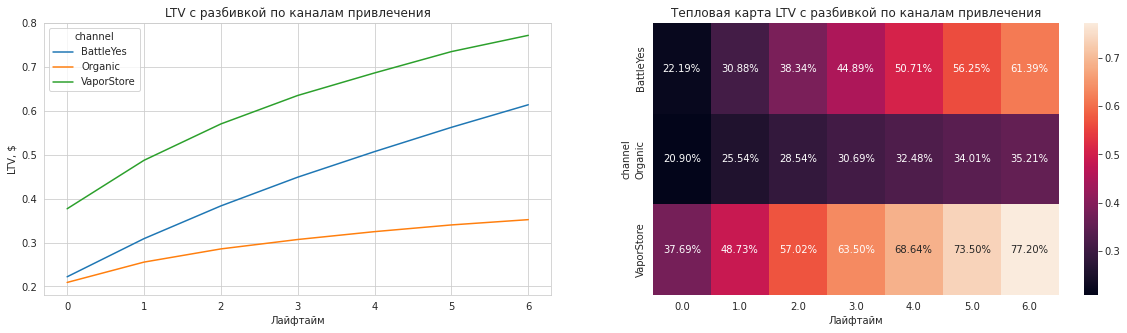

In [4]:
from IPython.core.display_functions import display
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


def get_ltv(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time


users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # данные о покупках

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

observation_date = users['dt'].max()  # момент анализа
analysis_horizon = 7  # горизонт анализа

ltv_raw, ltv, ltv_history =  get_ltv(profiles=users,
                                     purchases=purchases,
                                     observation_date=observation_date,
                                     horizon_days=analysis_horizon,
                                     dimensions=['channel'])# рассчитайте ltv с разбивкой по channel

plt.figure(figsize = (20, 5))  # размер сетки для графиков

# исключаем размеры когорт
report = ltv.drop(columns = ['cohort_size'])

# в одной ячейке таблицы графиков постройте кривые LTV
(report.T.plot(grid=True,
               xticks=list(report.columns.values),
               ax=plt.subplot(1, 2, 1)))
plt.title('LTV с разбивкой по каналам привлечения')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')

# в другой — хитмэп
sns.heatmap(report,
            annot=True,
            fmt='.2%',
            ax=plt.subplot(1, 2, 2))
plt.title('Тепловая карта LTV с разбивкой по каналам привлечения')
plt.xlabel('Лайфтайм')

plt.show()

# 2.
Рассчитайте LTV только для пользователей из канала Organic: передайте функции get_ltv() соответствующую часть датафрейма users.
На одной сетке постройте два графика: кривую LTV и график истории изменений LTV на первый, второй, третий и шестой дни «жизни» пользователей.

Подсказка
Отфильтруйте датафрейм users методом query(), передав ему такое условие: 'channel == "Organic"'.
Результат сохраните в переменную users или новую и передайте её функции get_ltv() вместе с другими аргументами — purchases, observation_date и analysis_horizon.
Чтобы построить график истории изменений, сделайте срез таблицы динамики LTV: ltv_history[[0, 1, 2, 5]].

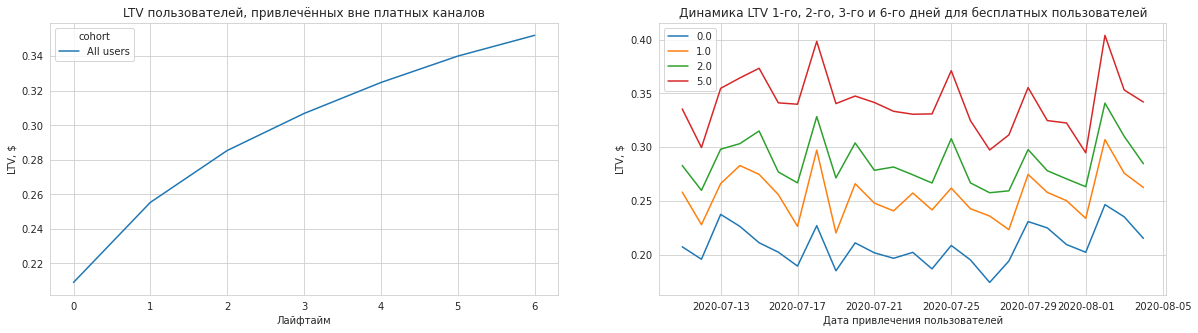

In [5]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


def get_ltv(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time


users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # данные о покупках

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

observation_date = users['dt'].max()  # момент анализа
analysis_horizon = 7  # горизонт анализа


# отфильтруйте данные пользователей из канала Organic

ltv_raw, ltv, ltv_history =  get_ltv(profiles=users.query('channel == "Organic"'),
                                     purchases=purchases,
                                     observation_date=observation_date,
                                     horizon_days=analysis_horizon)# рассчитайте LTV без разбивки


plt.figure(figsize=(20, 5))

report = ltv.drop(columns = ['cohort_size'])
report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('LTV пользователей, привлечённых вне платных каналов')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')


report =  ltv_history[[0, 1, 2, 5]]# сделайте срез таблицы динамики LTV

report.plot(grid=True, ax=plt.subplot(1, 2, 2))
plt.title(
    'Динамика LTV 1-го, 2-го, 3-го и 6-го дней для бесплатных пользователей'
)
plt.ylabel('LTV, $')
plt.xlabel('Дата привлечения пользователей')

plt.show()

# 3.
Используя таблицу динамики LTV и сортировку, определите дату, в которую «Королевство гномов» привлекло бесплатных пользователей с минимальным LTV шестого дня жизни.
Выведите на экран соответствующую часть фрейма ltv_history с датой и значением LTV.

Подсказка
Шестой день «жизни» соответствует пятому лайфтайму — сделайте срез таблицы динамики LTV, указав в квадратных скобках значение 5.
Отсортируйте результат методом sort_values() и получите первую строку методом head(), передав ему значение 1.

In [8]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


def get_ltv(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time


users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # данные о покупках

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

observation_date = users['dt'].max()  # момент анализа
analysis_horizon = 7  # горизонт анализа

users = users.query('channel == "Organic"')
ltv_raw, ltv, ltv_history = get_ltv(
    users, purchases, observation_date, analysis_horizon
)

print(ltv_history[5].sort_values().head(1))

dt
2020-08-01    0.294724
Name: 5.0, dtype: float64
